In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from joblib import dump, load

## **Preprocessing**

In [2]:
engStopWords = stopwords.words('english')
le = LabelEncoder()

In [3]:
def lemmatize(word):
    wnl = WordNetLemmatizer()
    word = wnl.lemmatize(word, pos='v')
    word = wnl.lemmatize(word, pos='n')
    word = wnl.lemmatize(word, pos='a')
    return word

In [4]:
def cleanText(text):
    # emojis pattern source is stackoverflow
    emoj = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+",
        re.UNICODE)

    # Removing links, non letters, eemojis, and turning to lower case
    text = re.sub(r'http\S+ ', '', text).lower()
    text = re.sub(r'[^a-zA-Z]+', ' ', text)
    text = re.sub(emoj, "", text)

    # Lemmatizing and removing stop words
    text = list(map(lemmatize, text.split()))
    text = ' '.join([word for word in text if word not in engStopWords])

    return text

In [5]:

df = pd.read_csv('./Suicide_Detection.csv')
df.head()


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [6]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:

# Encode the classes into 0 and 1
df['class'] = le.fit_transform(df['class'])

In [8]:
df.text = df.text.apply(cleanText)

In [9]:
cv = CountVectorizer(max_features=3000)

In [10]:
len(df)

232074

In [11]:
x_train, x_test, y_train, y_test = train_test_split(cv.fit_transform(df.text).toarray(), df['class'], test_size=0.3)

## **Model**

In [12]:
model = sklearn.linear_model.LogisticRegression(class_weight={0: 1, 1:2})

In [13]:
model.fit(x_train, y_train)

/home/nour/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 1, 1: 2})

In [14]:
y_pred = model.predict(x_test)

accuracy = model.score(x_test,y_test)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)

print(f"accuracy: {np.round(accuracy*100,2)}%\nprecision: {np.round(precision*100,2)}%\nrecall: {np.round(recall*100,2)}%")

accuracy: 92.49%
precision: 91.68%
recall: 93.38%


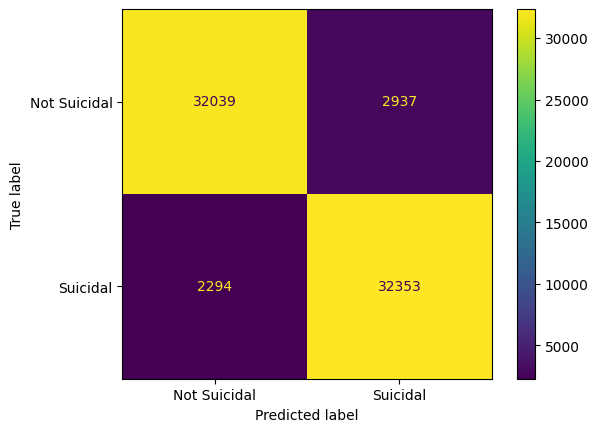

In [15]:

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Suicidal','Suicidal'])
disp.plot()
plt.show()

## Testing the model on any text

In [16]:
def classifyText(text):
    text = cleanText(text)
    text = cv.transform([text]).toarray()
    pred = model.predict(text)
    return "The text is suicidal" if pred else "The text is not suicidal"

In [17]:
text = "I am going to kill myself"
classifyText(text)

'The text is suicidal'

In [18]:
text = "I am doing alright"
classifyText(text)

'The text is not suicidal'

## Visualizing the word cloud of each class

In [20]:
from wordcloud import WordCloud

In [21]:
wc = WordCloud(stopwords=engStopWords, background_color='white',
               colormap='Dark2', max_font_size=50,width=400, height=200)

In [22]:
cloud = df.groupby('class').text.apply(lambda x: ' '.join(x))

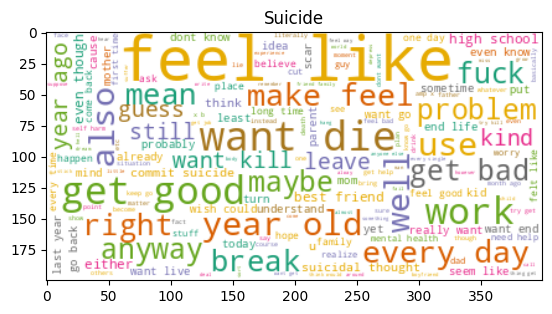

In [23]:
wc.generate(cloud[1])
plt.title("Suicide")
plt.imshow(wc, interpolation='bilinear')
plt.show()

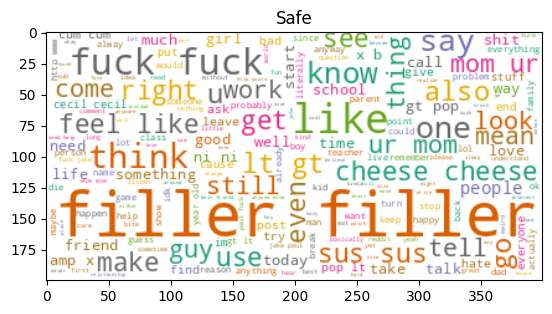

In [24]:
wc.generate(cloud[0])
plt.title("Safe")
plt.imshow(wc, interpolation='bilinear')
plt.show()

In [ ]:
# dump(cv, 'cv.joblib')
# dump(model, 'model.joblib')